In [11]:
import json, glob, re, os, sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import confusion_matrix as CM
import visualization as viz

class Result:
    """
    valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/sample200new/val.txt"
    pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/sample200_lr1_raw/best_predictions.json"
    obj = Result(valTxtPath, pdJsonPath, classL=['tetra'], classNumL=[1])
    obj.getPR()
    obj.getRefineRP()
    obj.getAPs()
    obj.plotPR()
    obj.plotConfusion()
    obj.getBlockImgs(1,0)
    """
    def __init__(self, valTxtPath, pdJsonPath, classL, classNumL):
        self.imgPathL, self.antPathL = self.getPath(valTxtPath)
        #print(self.imgPathL)
        #print(self.antPathL)
        self.labels   = self.getLabels()
        #print(self.labels)
        self.detections = self.getDetections(pdJsonPath)
        #print(self.detections)
        self.classL    = classL
        self.classNumL = classNumL
        self.savePath  = os.path.dirname(pdJsonPath) 
        
    def getPath(self, valTxtPath):
        imgPathL, antPathL = [], []
        for line in open(valTxtPath,"r").readlines():
            if line.replace("\n","")[-4:]==".jpg":
                imgPathL.append(line[:-1])
            else:
                antPathL.append(line[:-1])
        return sorted(imgPathL), sorted(antPathL)
        
    def getLabels(self):
        height, width, _ = cv2.imread(self.imgPathL[0]).shape
        labels = []
        for antPath in self.antPathL:
            label = []
            for line in open(antPath,"r").readlines():
                cid, cx, cy, w, h = line.replace("\n","").split(" ")
                xmin = (float(cx)-float(w)/2)*width
                ymin = (float(cy)-float(h)/2)*height
                xmax = (float(cx)+float(w)/2)*width
                ymax = (float(cy)+float(h)/2)*height
                label.append( [int(cid), int(xmin), int(ymin), int(xmax), int(ymax)] ) # yolo2voc # [cid, xmin, ymin, xmax, ymax]
            labels.append( np.array(label) )
        return labels
    
    def getDetections(self, pdJsonPath):
        L = json.load(open(pdJsonPath,"r")) # box: coco (xmin,ymin,w,h)
        img2Idx = { os.path.basename(imgPath).split('.')[0]:i for i,imgPath in enumerate(self.imgPathL) }
        detections = [ [] for _ in range(len(self.imgPathL)) ]
        for D in L:
            idx, cid, conf, (xmin,ymin,w,h) = img2Idx[D['image_id']], D['category_id']-1, D['score'], D['bbox']
            detections[idx].append( [xmin, ymin, xmin+w, ymin+h, conf, cid] ) # [xmin, ymin, xmax, ymax, conf, cid]
        return [ np.array(det) for det in detections ]
 
    def getPR(self):
        prPath = f"{self.savePath}/pr.npy"
        if glob.glob(prPath):
            print("load pr.npy from cache")
            self.PR = np.load(prPath, allow_pickle=True)
        else:
            n = len(self.classL)
            self.PR = [ {"precision":[0.]*101, "recall":[0.]*101} for i in range(n) ]
            for i in range(101):
                print(f"\rthreshold={round(i*0.01,2)}{'0' if i%10==0 else ''}", end="")
                M = np.zeros( (n+1,n+1) ) # col:gt, row:pd
                for j,(labels,detections) in enumerate(zip(self.labels,self.detections)):
                    cm = CM.ConfusionMatrix(n, CONF_THRESHOLD=i*0.01, IOU_THRESHOLD=0.5)
                    cm.process_batch(detections,labels)
                    M += cm.return_matrix()
                #
                rowSum, colSum = M.sum(axis=1), M.sum(axis=0)
                for j in range(n):
                    self.PR[j]["precision"][i] = M[j][j]/rowSum[j] if rowSum[j] else 0
                    self.PR[j]["recall"][i]    = M[j][j]/colSum[j] if colSum[j] else 0
            np.save(prPath, self.PR)
            print()
        #print(f"self.PR={self.PR}")
    
    def getRefineRP(self): # sorted by recall, and enhance precision by next element reversely
        n = len(self.classL)
        for i in range(n):
            R, P = self.PR[i]["recall"][:], self.PR[i]["precision"][:]
            Z = sorted(zip(R,P))
            R, P = zip(*Z)
            R, P = list(R), list(P)
            for j in range(1,101):
                P[-1-j] = max(P[-1-j], P[-j])
            self.PR[i]["refineRecall"], self.PR[i]["refinePrecision"] = R, P
        #print(f"self.PR={self.PR}")

    def getAPs(self):
        self.apL, self.mAP, self.wmAP, n = [], 0, 0, len(self.classL)
        for i in range(n):
            ap = 0
            for j in range(100):
                ap += self.PR[i]["refinePrecision"][j]*(self.PR[i]["refineRecall"][j+1]-self.PR[i]["refineRecall"][j])
            self.apL.append( round(ap,3) )
            self.mAP  += ap/n
            self.wmAP += ap*self.classNumL[i]/sum(self.classNumL)
        self.mAP  = round(float(self.mAP),3)
        self.wmAP = round(float(self.wmAP),3)
        print(f"apL={self.apL}, mAP={self.mAP}, wmAP={self.wmAP}")
    
    def plotAP(self, showMAP=False, showAPS=False):
        R = list(range(len(self.classL)))
        plt.figure()
        ax = plt.subplot(1,1,1)
        ax.set_title(f"{'mAP='+str(self.mAP)+', ' if showAPS else ''}wmAP={self.wmAP}", fontsize=16)
        ax.bar(self.classL, self.apL)
        if showAPS:
            for i in range(len(self.classL)):
                ax.text(R[i], self.apL[i], self.apL[i], ha="center", va="bottom", fontsize=16)
        plt.savefig(f"{self.savePath}/ap.jpg")
        plt.show()
                    
    def plotPR(self):
        n = len(self.classL)
        plt.figure(figsize=(6*n,4*2+3))
        for i in range(n):
            plt.subplot(2,n,1+i)
            plt.scatter( self.PR[i]["refineRecall"], self.PR[i]["refinePrecision"] )
            plt.plot( self.PR[i]["refineRecall"], self.PR[i]["refinePrecision"] )
            plt.xlim(-0.05,1.05)
            plt.ylim(-0.05,1.05)
            plt.grid('on')
            plt.title(f"class-{i}", fontsize=16)
            plt.xlabel("recall", fontsize=16)
            plt.ylabel("precision", fontsize=16)

            plt.subplot(2,n,1+i+n)
            plt.plot( self.PR[i]["precision"])
            plt.plot( self.PR[i]["recall"])
            plt.plot( [(self.PR[i]["precision"][j]+self.PR[i]["recall"][j])/2 for j in range(101)] )
            plt.xlim(-5,105)
            plt.ylim(-0.05,1.05)
            plt.grid('on')
            plt.title(f"class-{i}", fontsize=16)
            plt.xlabel("threshold", fontsize=16)
            plt.legend(labels=["precision","recall","fvalue"], fontsize=12)
        plt.savefig(f"{self.savePath}/pr.jpg")
        plt.show()
    
    def _getBestThreshold(self):
        n = len(self.classL)
        wScore = [0]*101
        for i in range(101):
            for j in range(n):                
                p, r = self.PR[j]["precision"][i], self.PR[j]["recall"][i]
                if self.strategy=="fvalue":
                    score = 2*p*r/(p+r) if p+r else 0
                elif self.strategy=="precision":
                    score = p if r>=0.5 else 0
                else:
                    raise
                wScore[i] += score*self.classNumL[j]/sum(self.classNumL)
        bestScore, self.bestThreshold = max(zip(wScore,[round(0.01*i,2) for i in range(101)]))
        print(f"bestScore={round(bestScore,2)}, best_threshold={self.bestThreshold}")
    
    def plotConfusion(self, strategy="precision"): # "fvalue"
        self.strategy = strategy
        self._getBestThreshold()
        n = len(self.classL)
        M = np.zeros( (n+1,n+1) ) # col:gt, row:pd
        self.accumFileL = [ [[] for j in range(n+1)] for i in range(n+1) ] # (n+1,n+1) each grid is path list
        for j,(imgPath,labels,detections) in enumerate(zip(self.imgPathL,self.labels,self.detections)):
            cm = CM.ConfusionMatrix(n, CONF_THRESHOLD=self.bestThreshold, IOU_THRESHOLD=0.5, gtFile=imgPath, accumFileL=self.accumFileL)
            cm.process_batch(detections,labels)
            M += cm.return_matrix()
            self.accumFileL = cm.getAccumFileL()
        #
        #print(M)
        axis0sum = M.sum(axis=0)
        N = M.copy()
        for i in range(len(N)):
            if axis0sum[i] != 0:
                N[:,i] /= axis0sum[i]
        #print(N)
        axis1sum = M.sum(axis=1)
        P = M.copy()
        for i in range(len(P)):
            if axis1sum[i] != 0:
                P[i,:] /= axis1sum[i]
        #print(P)
        #
        plt.figure(figsize=(15,5))
        # fig1 - number
        fig = plt.subplot(1,3,1)
        plt.title(f"Confusion Matrix - Number (conf={self.bestThreshold})", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks(np.arange(n+1)) # values
        fig.set_xticklabels(self.classL+['BG']) # labels
        fig.set_yticks(np.arange(n+1)) # values
        fig.set_yticklabels(self.classL+['BG']) # labels
        plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(n+1):
            for j in range(n+1):
                plt.text(j, i, int(M[i][j]), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
        # fig2 - precision
        fig = plt.subplot(1,3,2)
        plt.title(f"Confusion Matrix - Row norm (Precision)", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks(np.arange(n+1)) # values
        fig.set_xticklabels(self.classL+['BG']) # labels
        fig.set_yticks(np.arange(n+1)) # values
        fig.set_yticklabels(self.classL+['BG']) # labels
        plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(n+1):
            for j in range(n+1):
                plt.text(j, i, round(P[i][j],3), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
        # fig3 - recall
        fig = plt.subplot(1,3,3)
        plt.title(f"Confusion Matrix - Col norm (Recall)", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks(np.arange(n+1)) # values
        fig.set_xticklabels(self.classL+['BG']) # labels
        fig.set_yticks(np.arange(n+1)) # values
        fig.set_yticklabels(self.classL+['BG']) # labels
        plt.imshow(N, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(n+1):
            for j in range(n+1):
                plt.text(j, i, round(N[i][j],3), ha="center", va="center", color="black" if N[i][j]<0.9 else "white", fontsize=12)
        #plt.colorbar(mpl.cm.ScalarMappable(cmap=mpl.cm.Blues))
        plt.savefig(f"{self.savePath}/confusion.jpg")
        plt.show()
        json.dump(self.accumFileL, open(f"{self.savePath}/confusionFiles.json","w"))
        
    def getBlockImgs(self, row, col, threshold='best'): # PD, GT
        classL = self.classL + ['BG']
        folder = f"{self.savePath}/GT_{classL[col]}_PD_{classL[row]}"
        os.makedirs(folder, exist_ok=True)
        threshold = self.bestThreshold if threshold=='best' else threshold 
        for imgPath in self.accumFileL[row][col]:
            idx = self.imgPathL.index(imgPath)
            det = self.detections[idx]
            if not len(det):
                continue
            det = det[det[:,4]>threshold]
            viz.show( imgPath, imgPath.replace('.jpg','.txt'), 'voc', det[:,:4], det[:,5].astype(int), det[:,4], self.classL, folder, (1.7,1.7) )
        print(f"len(glob.glob(folder+'/*.jpg'))={len(glob.glob(folder+'/*.jpg'))}")

threshold=1.00
apL=[0.968], mAP=0.968, wmAP=0.968


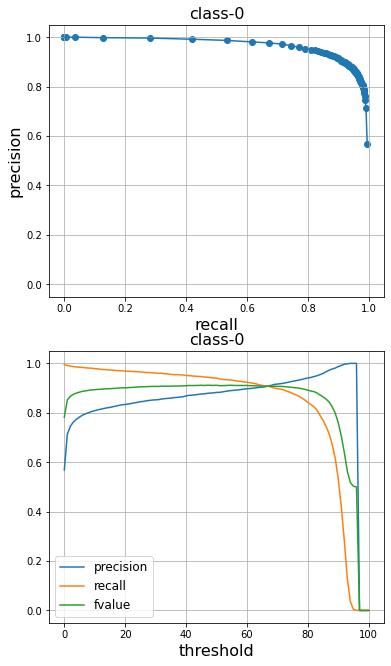

bestScore=0.99, best_threshold=0.9


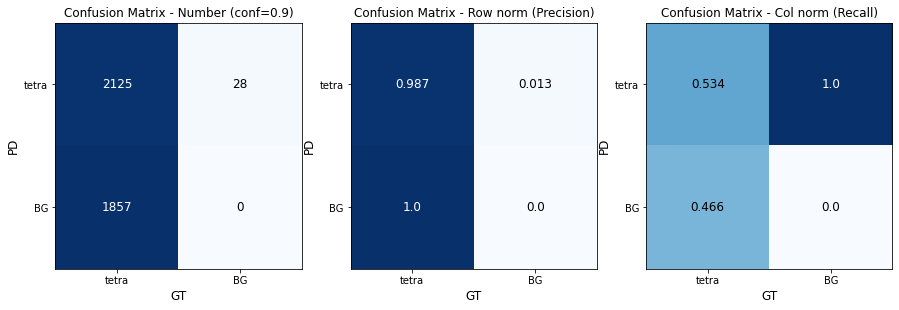

len(glob.glob(folder+'/*.jpg'))=28
bestScore=0.91, best_threshold=0.55


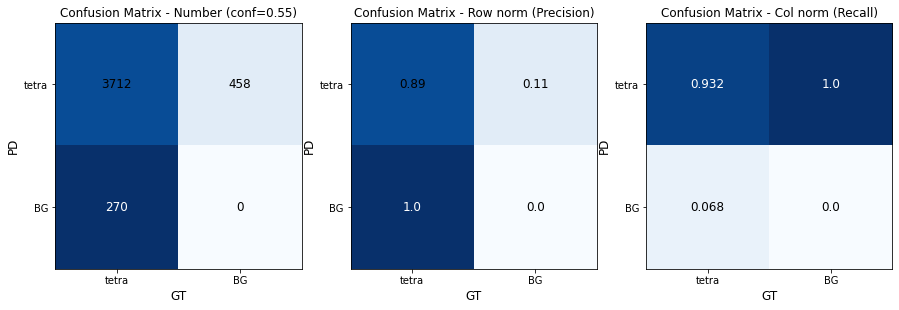

len(glob.glob(folder+'/*.jpg'))=176


In [7]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/tetraV8/val.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/tetrav8v0/best_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['tetra'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss

load pr.npy from cache
apL=[0.995], mAP=0.995, wmAP=0.995


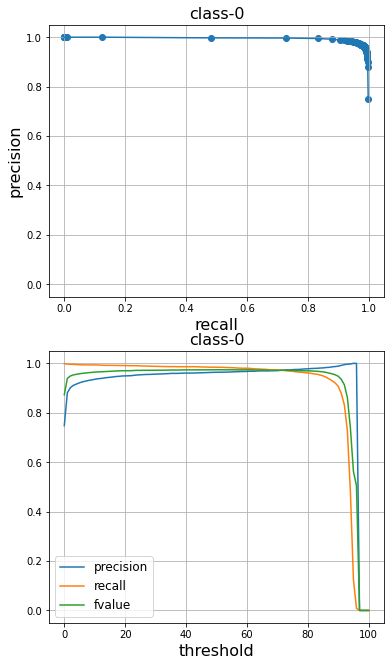

bestScore=1.0, best_threshold=0.93


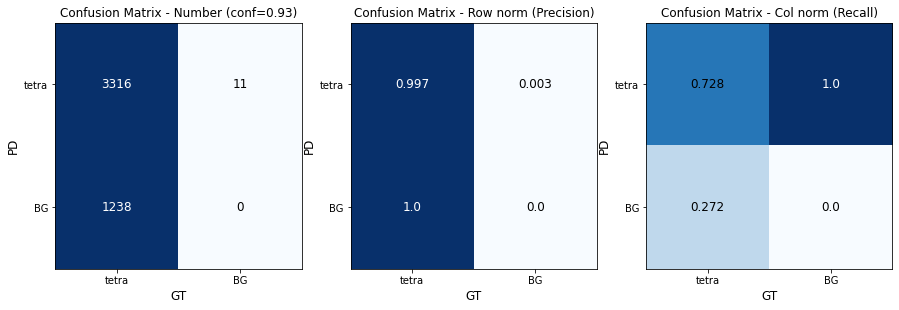

len(glob.glob(folder+'/*.jpg'))=10
bestScore=0.97, best_threshold=0.5


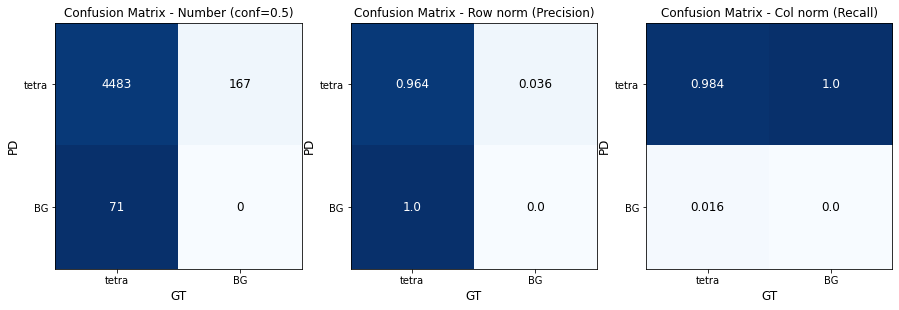

len(glob.glob(folder+'/*.jpg'))=62


In [9]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/tetraV9/val.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/tetrav9v0/best_474_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['tetra'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss

load pr.npy from cache
apL=[0.998], mAP=0.998, wmAP=0.998


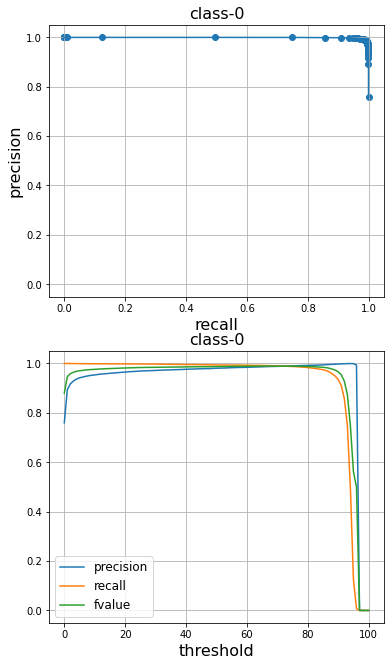

bestScore=1.0, best_threshold=0.93


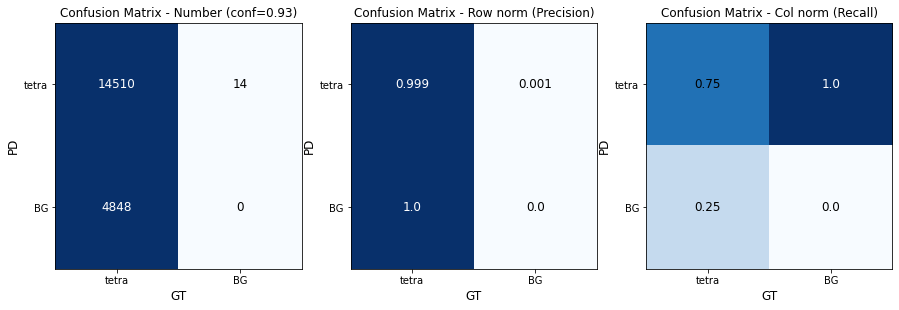

len(glob.glob(folder+'/*.jpg'))=13
bestScore=0.99, best_threshold=0.68


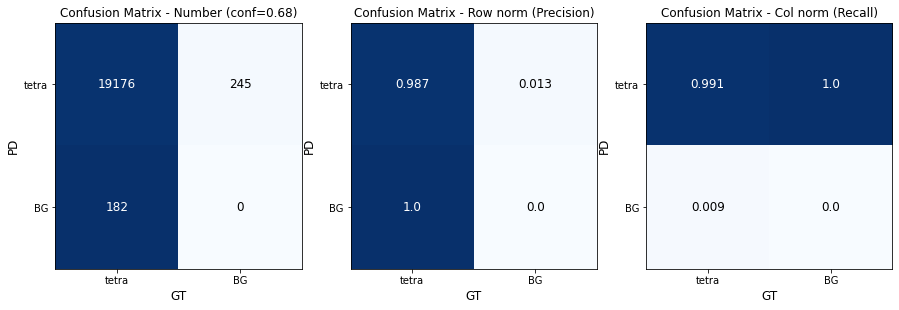

len(glob.glob(folder+'/*.jpg'))=172


In [13]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/tetraV9/train.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/tetrav9v0_training/best_474_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['tetra'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss

threshold=1.00
apL=[0.998], mAP=0.998, wmAP=0.998


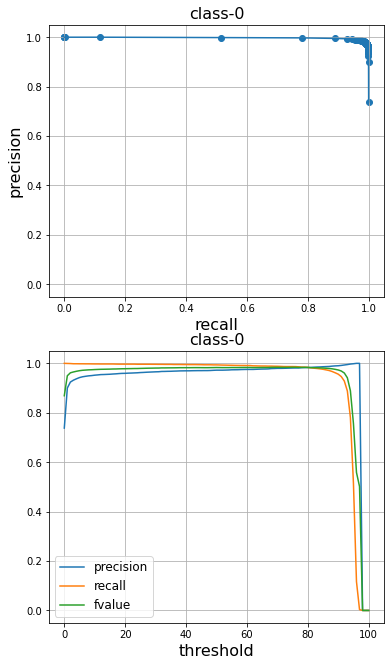

bestScore=1.0, best_threshold=0.95


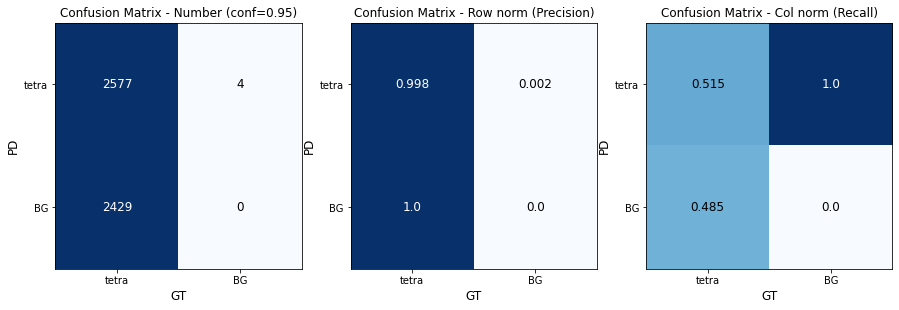

len(glob.glob(folder+'/*.jpg'))=4
bestScore=0.98, best_threshold=0.75


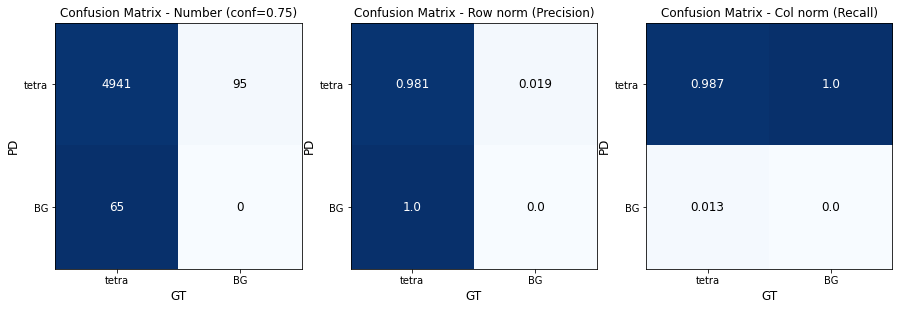

len(glob.glob(folder+'/*.jpg'))=63


In [14]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/tetraV10/val.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/tetrav10v0/best_727_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['tetra'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss

load pr.npy from cache
apL=[1.0], mAP=1.0, wmAP=1.0


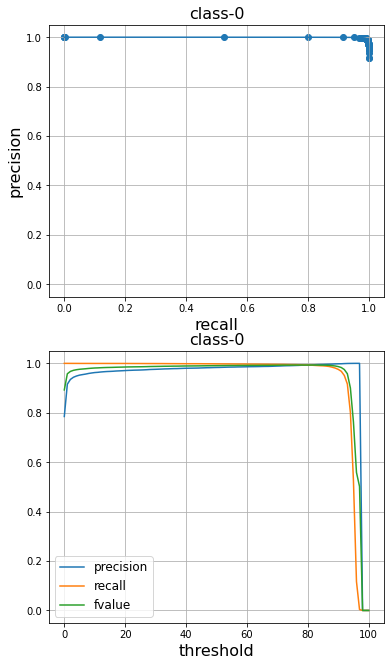

bestScore=1.0, best_threshold=0.95


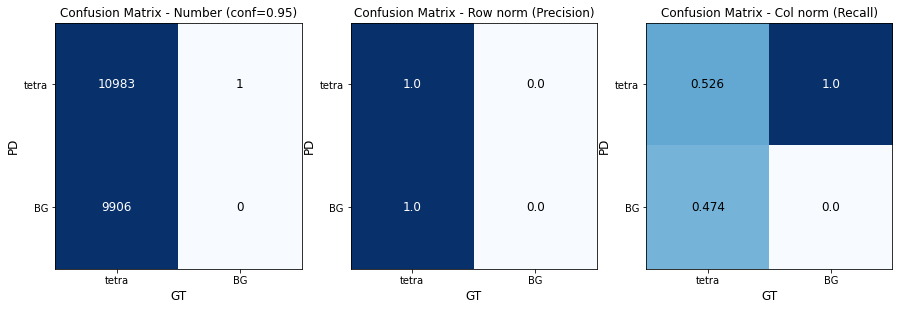

len(glob.glob(folder+'/*.jpg'))=1
bestScore=0.99, best_threshold=0.78


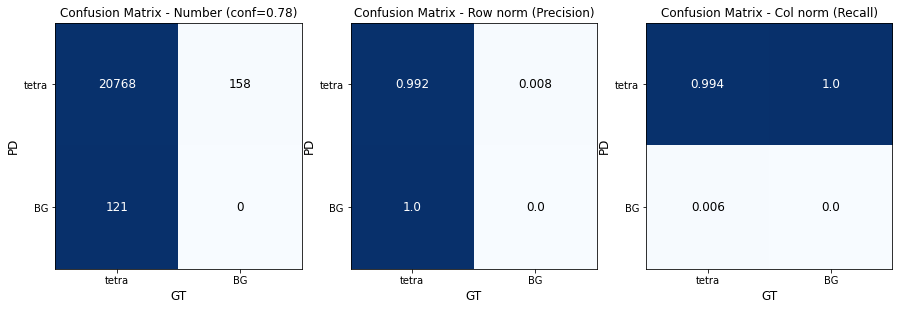

len(glob.glob(folder+'/*.jpg'))=117


In [17]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/tetraV10/train.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/tetrav10v0_training/best_727_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['tetra'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss

threshold=1.00
apL=[0.998], mAP=0.998, wmAP=0.998


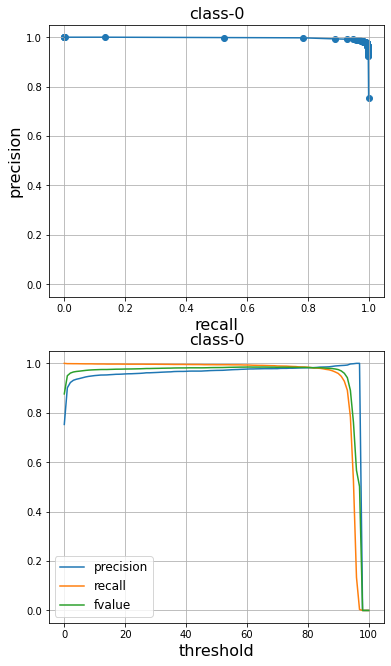

bestScore=1.0, best_threshold=0.95


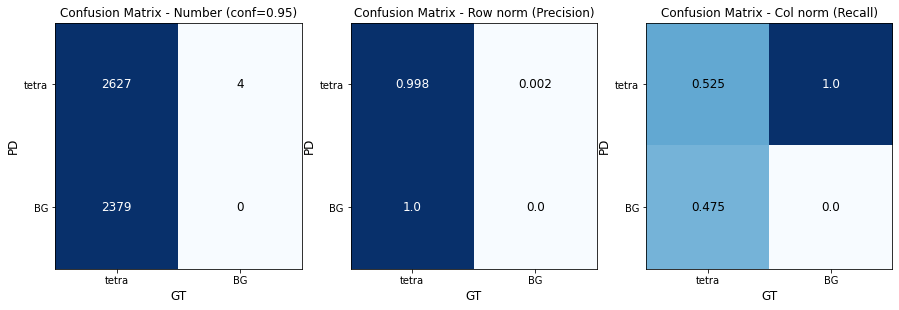

bestScore=0.99, best_threshold=0.61


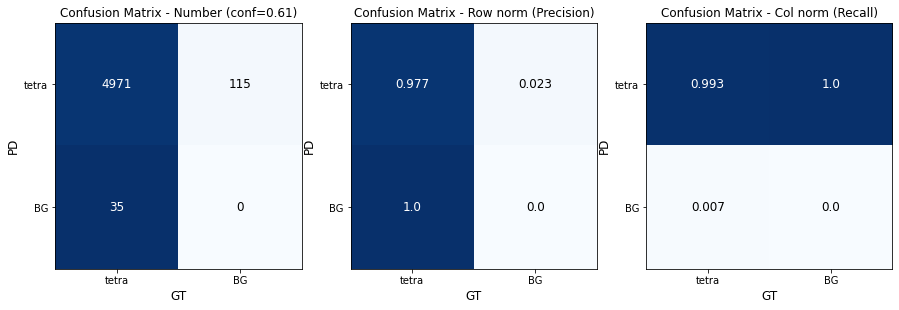

In [18]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/tetraV10V1/val.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/tetrav10v1/best_742_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['tetra'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
#obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
#obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss

load pr.npy from cache
apL=[0.999], mAP=0.999, wmAP=0.999


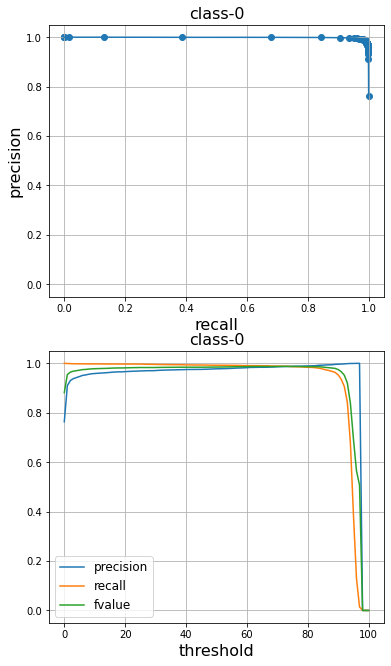

bestScore=1.0, best_threshold=0.94


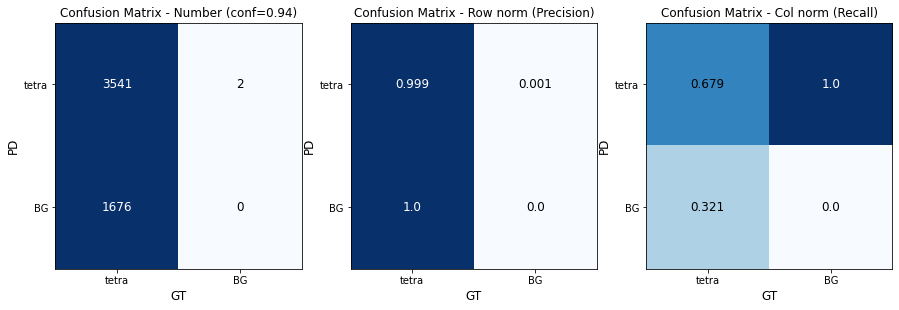

len(glob.glob(folder+'/*.jpg'))=2
bestScore=0.99, best_threshold=0.72


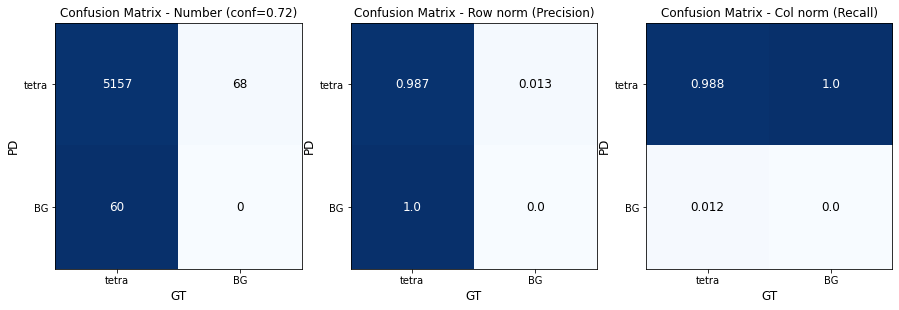

len(glob.glob(folder+'/*.jpg'))=58


In [7]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/tetraV11/val.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/tetrav11v0/best_795_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['tetra'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss

load pr.npy from cache
apL=[0.998], mAP=0.998, wmAP=0.998


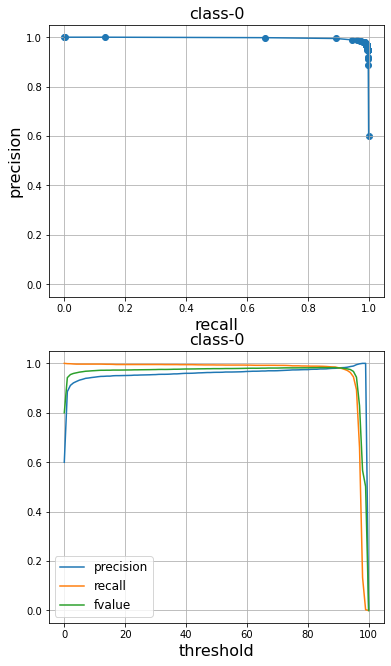

bestScore=1.0, best_threshold=0.97


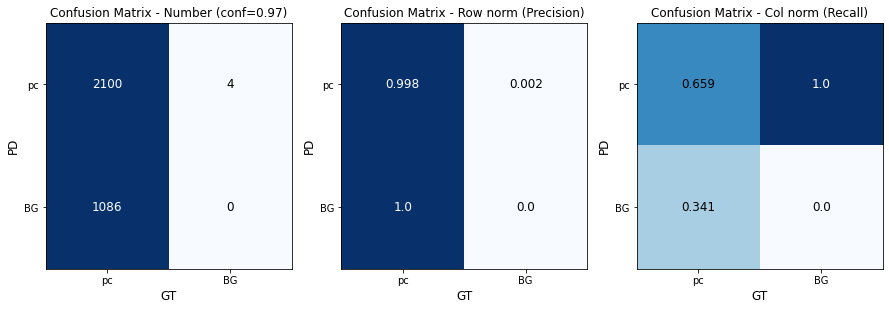

len(glob.glob(folder+'/*.jpg'))=4
bestScore=0.98, best_threshold=0.84


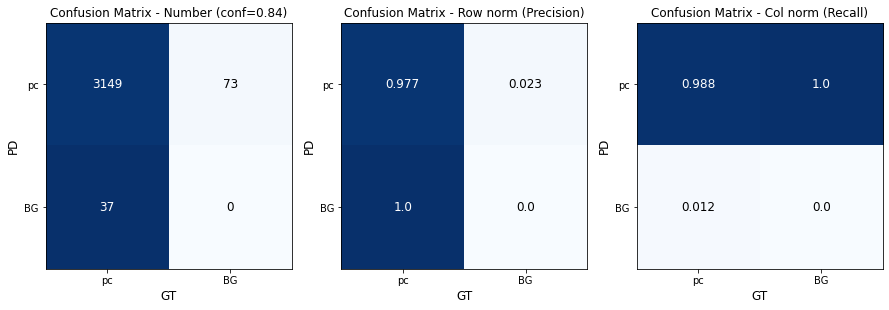

len(glob.glob(folder+'/*.jpg'))=35


In [5]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/pcV1/val.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/pcv1v0/best_267_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['pc'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss

threshold=1.00
apL=[0.998], mAP=0.998, wmAP=0.998


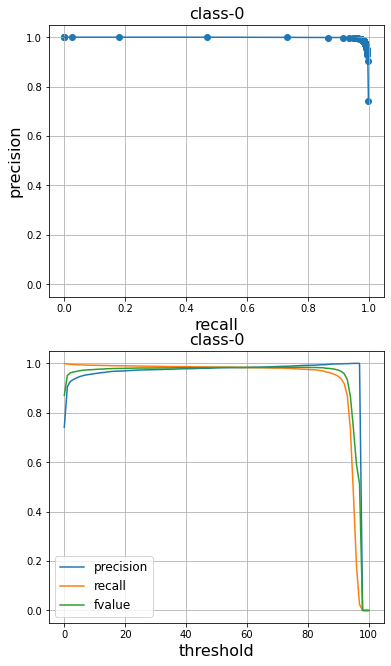

bestScore=1.0, best_threshold=0.94


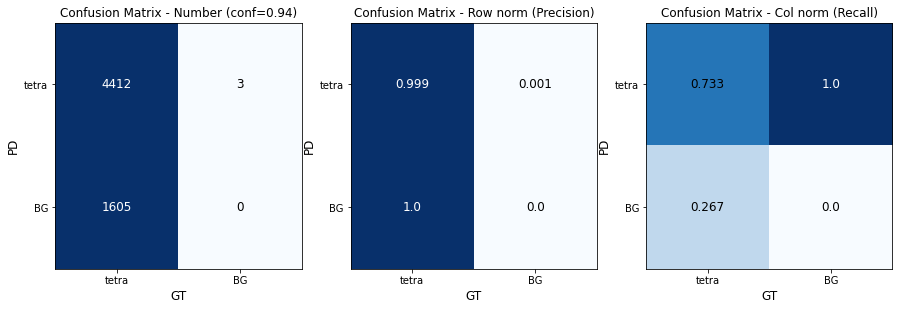

len(glob.glob(folder+'/*.jpg'))=3
bestScore=0.98, best_threshold=0.72


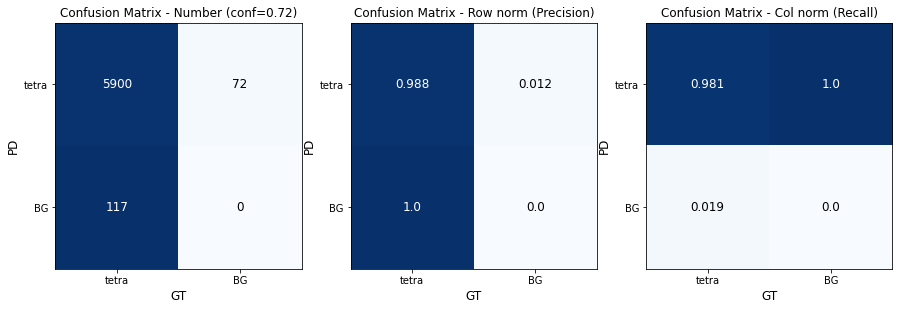

len(glob.glob(folder+'/*.jpg'))=101


In [8]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/tetraV12/val.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/tetrav12v0/best_813_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['tetra'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss

threshold=1.00
apL=[0.999], mAP=0.999, wmAP=0.999


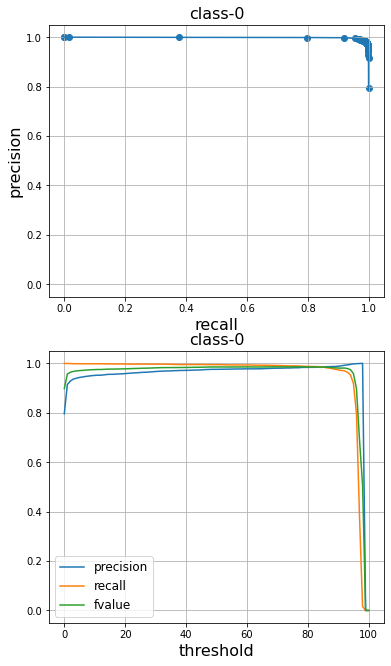

bestScore=1.0, best_threshold=0.96


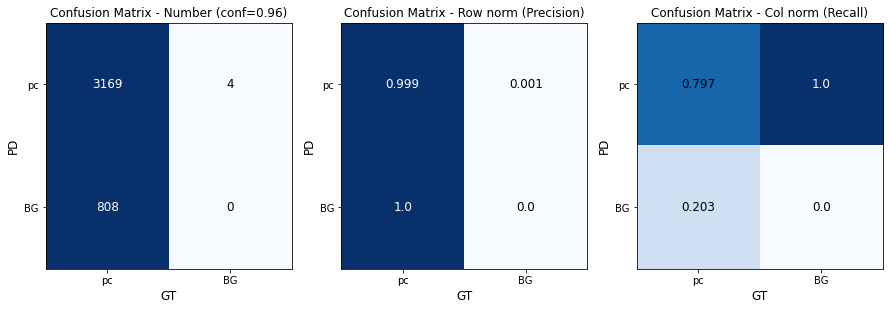

len(glob.glob(folder+'/*.jpg'))=4
bestScore=0.99, best_threshold=0.69


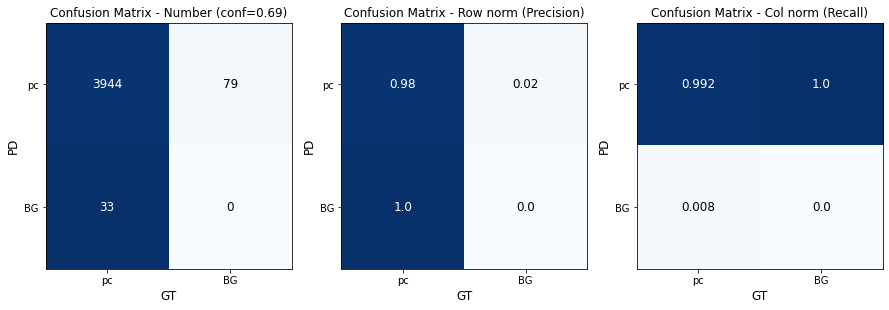

len(glob.glob(folder+'/*.jpg'))=31


In [9]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/pcV2/val.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/pcv2v0/best_582_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['pc'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss

threshold=1.00
apL=[0.999], mAP=0.999, wmAP=0.999


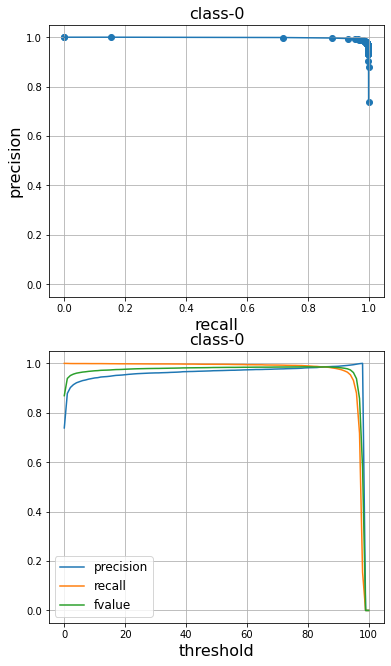

bestScore=1.0, best_threshold=0.97


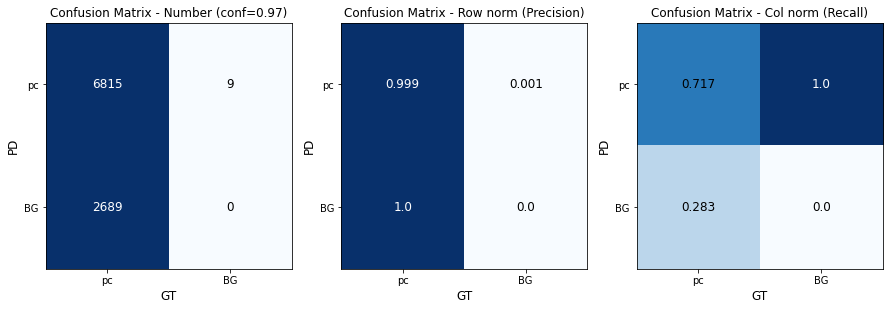

len(glob.glob(folder+'/*.jpg'))=9
bestScore=0.99, best_threshold=0.79


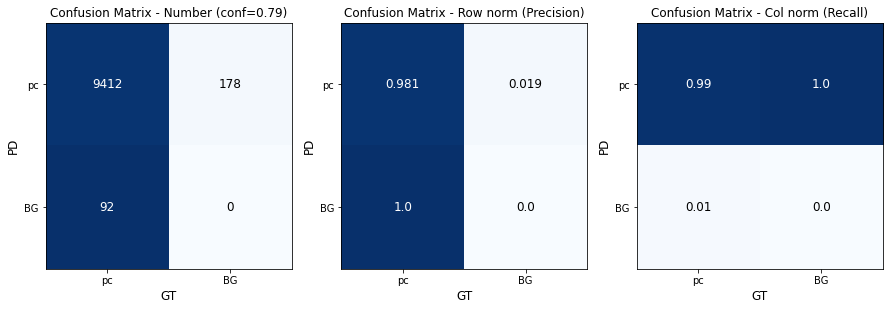

len(glob.glob(folder+'/*.jpg'))=86


In [13]:
valTxtPath = "/home/jovyan/data-vol-1/yolov7/_data/pcV3/val.txt"
pdJsonPath = "/home/jovyan/data-vol-1/yolov7/runs/test/pcv3v0/best_691_predictions.json"
obj = Result(valTxtPath, pdJsonPath, classL=['pc'], classNumL=[1])
obj.getPR()
obj.getRefineRP()
obj.getAPs()
obj.plotPR()
obj.plotConfusion()
obj.getBlockImgs(0,1)      # use precision strategy (high threshold) to check overkill
obj.plotConfusion("fvalue")
obj.getBlockImgs(1,0,0.02) # use fvalue strategy (low threshold) to check miss